In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pyreadstat
# from google.colab import drive
import joblib
import os

In [ ]:
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# os.listdir('/content/drive/My Drive/ML-datasets')

['animal_dataset.csv',
 'database_file.csv',
 'cell_towers.csv.gz',
 'governance.sav']

In [4]:
df, meta = pyreadstat.read_sav('../data/governance.sav')


In [5]:
# Replace missing logic values with NaN
df.replace([-1, 9, ''], np.nan, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17692\624501248.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([-1, 9, ''], np.nan, inplace=True)


In [6]:
print(df.isna().sum())

RESPNO                     0
COUNTRY                 1200
COUNTRY.old.spelling    1200
COUNTRY_R7List          1200
COUNTRY_R6List             0
                        ... 
R4.only                    0
R5.only                    0
R6.only                    0
R7.only                    0
R8.only                    0
Length: 421, dtype: int64


In [8]:
# Features to use in model

features = [
    "Q20", "Q21A", "Q24", "Q34A",   # Trust & Inclusion
    "Q26", "Q28",                   # Corruption Experience
    "Q32A", "Q32B",                 # Service Access
    "Q48A", "Q48B",                 # Speech Freedom
    "Q50A", "Q50B", "Q50C",         # Democratic Values
    "Q51A", "Q51B",                 # Civic Engagement
    "Q53A", "Q53B", "Q53C",         # Protest & Action
    "Q35A", "Q36A",                 # Fairness
    "Q38A", "Q38B", "Q38C"          # Inclusion
]

# Target label: perception of government performance

target_column = "Q23"

# Drop rows with missing target
df = df[df[target_column].notna()]

# Impute Missing Values

X_raw = df[features]
y = df[target_column].values

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_raw)

# Standardization
X_normalized = (X_imputed - X_imputed.mean(axis=0)) / X_imputed.std(axis=0)

# Add bias term (column of 1s)
X = np.c_[np.ones(X_normalized.shape[0]), X_normalized]

In [9]:
#divide data into  training data and testing data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Linear Regression using Gradient Descent

m = np.zeros(x_train.shape[1])
learning_rate = 0.01
epochs = 1000
train_losses = []
test_losses = []

# gradient descent loop
for epoch in range(epochs):
    y_train_pred = x_train.dot(m)
    train_error = y_train_pred - y_train

    #gradients (derivatives) o calculating how m and be affect errror
    gradient = (2 / len(x_train)) * x_train.T.dot(train_error)
    #update values or adjust m and b to reduce error
    m -= learning_rate * gradient

    #update losses for plotting later
    train_loss = np.mean(train_error ** 2)
    test_loss = np.mean((x_test.dot(m) - y_test) ** 2)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    #return the MSE
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train MSE = {train_loss:.4f}, Test MSE = {test_loss:.4f}")

Epoch 0: Train MSE = 7.1168, Test MSE = 6.8175
Epoch 100: Train MSE = 0.7110, Test MSE = 0.6918
Epoch 200: Train MSE = 0.5983, Test MSE = 0.5863
Epoch 300: Train MSE = 0.5963, Test MSE = 0.5848
Epoch 400: Train MSE = 0.5962, Test MSE = 0.5849
Epoch 500: Train MSE = 0.5962, Test MSE = 0.5849
Epoch 600: Train MSE = 0.5961, Test MSE = 0.5849
Epoch 700: Train MSE = 0.5961, Test MSE = 0.5849
Epoch 800: Train MSE = 0.5961, Test MSE = 0.5850
Epoch 900: Train MSE = 0.5961, Test MSE = 0.5850


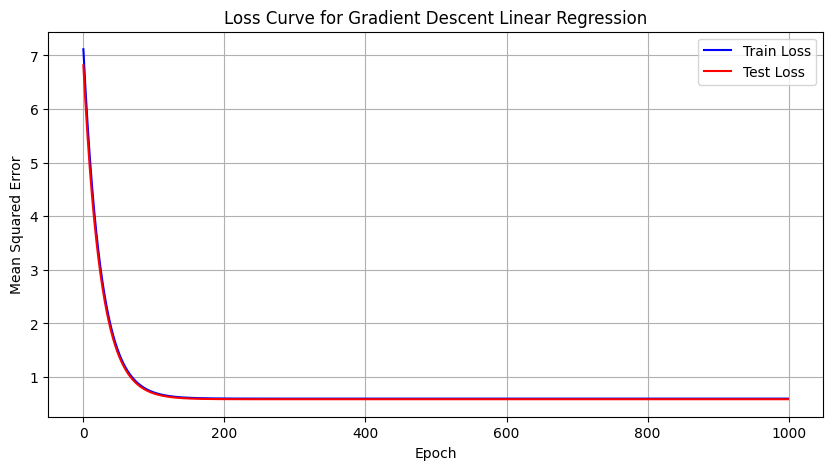

In [11]:
# Visualize Loss Curve

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss',color='red')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Loss Curve for Gradient Descent Linear Regression")
plt.legend()
plt.grid(True)
plt.show()

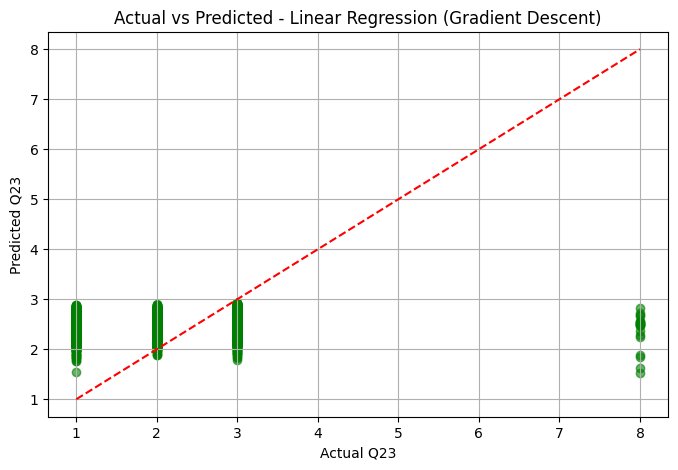

In [12]:
# Predicted vs Actual Scatter Plot

y_pred = x_test.dot(m)

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Q23")
plt.ylabel("Predicted Q23")
plt.title("Actual vs Predicted - Linear Regression (Gradient Descent)")
plt.grid(True)
plt.show()

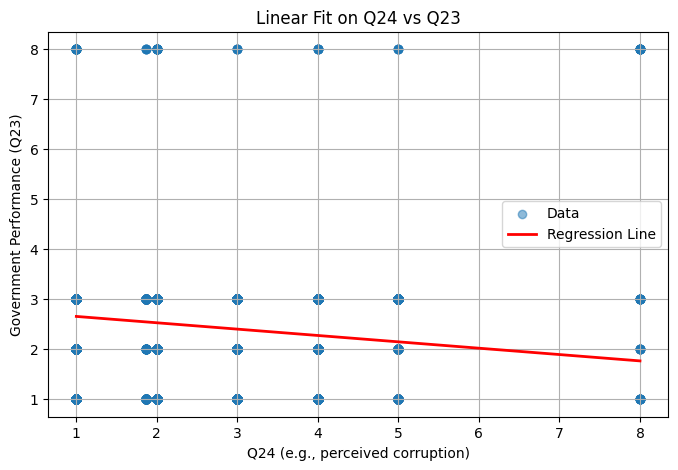

In [13]:
# visualizing linear fit for a single feature
feature_name = "Q24"
feature_index = features.index(feature_name)

X_feature = X_imputed[:, feature_index]
y_target = y

# Train Linear Regression on Q24 feature
X_feature_reshaped = X_feature.reshape(-1, 1)
simple_model = LinearRegression()
simple_model.fit(X_feature_reshaped, y_target)

# Generate regression line
x_line = np.linspace(X_feature.min(), X_feature.max(), 100).reshape(-1, 1)
y_line = simple_model.predict(x_line)

# Plot scatter with linear line
plt.figure(figsize=(8, 5))
plt.scatter(X_feature, y_target, alpha=0.5, label='Data')
plt.plot(x_line, y_line, color='red', linewidth=2, label='Regression Line')
plt.xlabel(f"{feature_name} (e.g., perceived corruption)")
plt.ylabel("Government Performance (Q23)")
plt.title(f"Linear Fit on {feature_name} vs Q23")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Comparing model models
 # sklearn models
x_train_sklearn, x_test_sklearn, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Linear Regression (Sklearn)
lr_model = LinearRegression()
lr_model.fit(x_train_sklearn, y_train)
lr_pred = lr_model.predict(x_test_sklearn)
lr_mse = mean_squared_error(y_test, lr_pred)

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(x_train_sklearn, y_train)
dt_pred = dt_model.predict(x_test_sklearn)
dt_mse = mean_squared_error(y_test, dt_pred)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(x_train_sklearn, y_train)
rf_pred = rf_model.predict(x_test_sklearn)
rf_mse = mean_squared_error(y_test, rf_pred)

# Print MSEs
print(f"\nModel Performance (MSE):")
print(f"Linear Regression (Sklearn): {lr_mse:.4f}")
print(f"Decision Tree: {dt_mse:.4f}")
print(f"Random Forest: {rf_mse:.4f}")


Model Performance (MSE):
Linear Regression (Sklearn): 0.5849
Decision Tree: 1.1913
Random Forest: 0.5787


In [ ]:
# Save Best Model

# Define the directory path (same loction ad this model)
model_dir = os.getcwd()

best_model = min([(lr_model, lr_mse), (dt_model, dt_mse), (rf_model, rf_mse)], key=lambda x: x[1])[0]
joblib.dump(best_model, os.path.join(model_dir, 'best_model.pkl'))
print("Best model saved as best_model.pkl")

Best model saved as best_model.pkl


In [19]:
# Prediction Script for best model
def predict_q23(new_data):
    model = joblib.load('best_model.pkl')
    new_data = np.array(new_data).reshape(1, -1)
    prediction = model.predict(new_data)
    return prediction[0]